In [242]:
import jdc.jdc as jdc
import networkx as nx
from constants import N, PROB_OF_ASSOCIATION, \
    PROB_OF_ANTI_VAC, COST_RATIO, PERCIEVED_INFECTION_RATE
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams.update({'axes.titlesize':'50'})

Populating the interactive namespace from numpy and matplotlib


In [243]:
'''Constants'''
INFECTION_RATE = float(10)
PERCIEVED_INFECTION_RATE = INFECTION_RATE
INFECTION_RISK = float(10)
RECOVERY_RATE = float(0.312)
N = 788
REPRODUCTION_NUMBER = float(5)
MEAN_ASSOCIATIONS = float(35)
PROB_OF_ASSOCIATION = MEAN_ASSOCIATIONS / N
COST_RATIO = float(0.5)
PROB_OF_ANTI_VAC = 0.1
RESPONSIVENESS = 5

I_START = max(N * 0.01, 1)

## Modelling the Impact of Social Influence on Individual's’ Vaccination Decision Making
### Zachary Newman 21149116

Influe

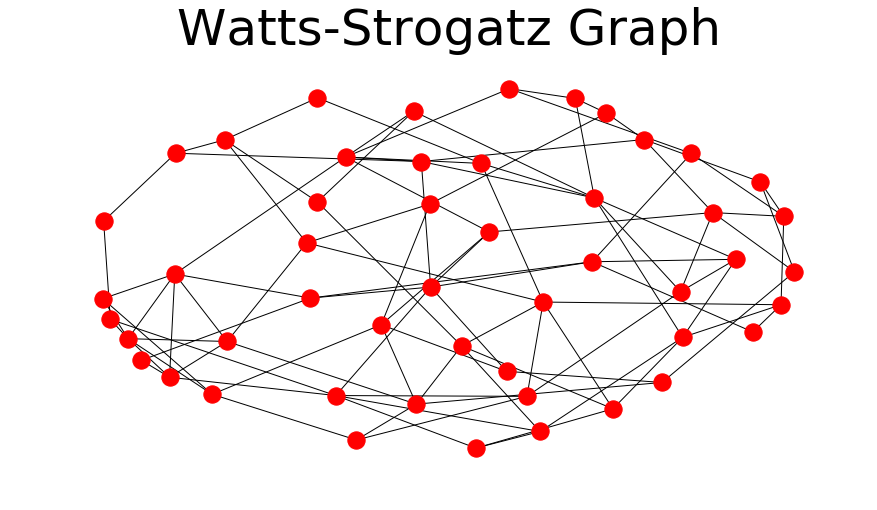

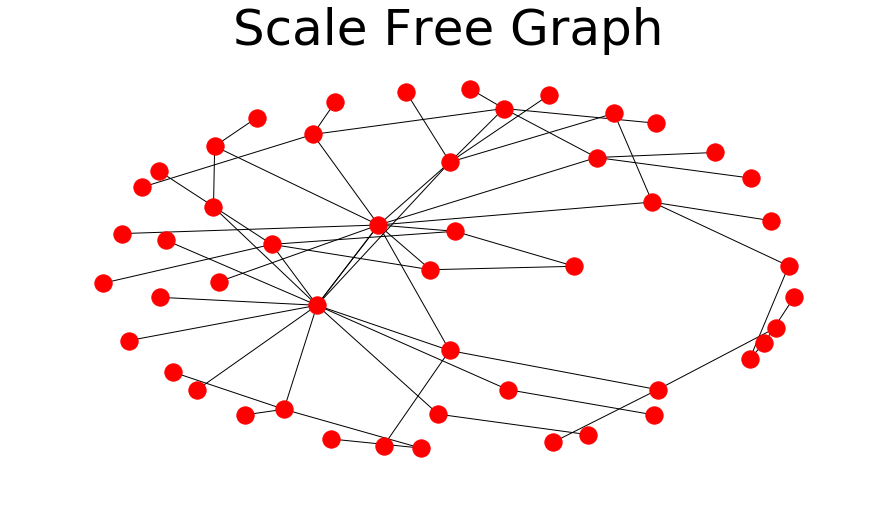

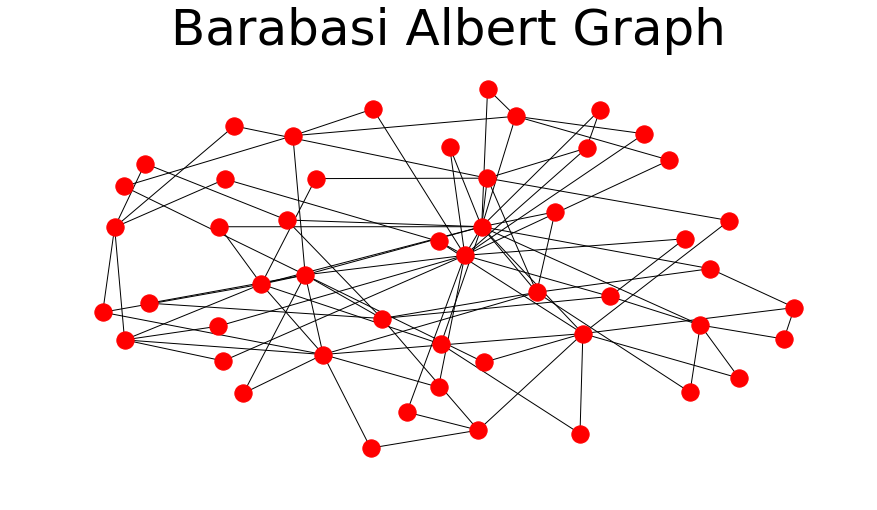

In [244]:
'''Graph for social network of individuals'''
class SocialNetworkGraph:

    def __init__(self, size):
        self.graphs = []
        self.labels = ['Watts-Strogatz Graph', 'Scale Free Graph', 'Barabasi Albert Graph']
        self.graphs.append(nx.watts_strogatz_graph(size, 4, 0.5))
        self.graphs.append(nx.scale_free_graph(
            size, alpha=0.4, beta=0.2, gamma=0.4, delta_in=0, delta_out=0).to_undirected())
        self.graphs.append(nx.barabasi_albert_graph(size, 2))
        for i, g in enumerate(self.graphs):
            for i in g.nodes():
                g.node[i]['decision'] = \
                    np.random.choice([1,-1], p=[1-PROB_OF_ANTI_VAC, PROB_OF_ANTI_VAC])
                g.node[i]['weight'] = float(np.random.binomial(1000, 0.5, 1))/float(1000)
                g.node[i]['social-influence'] = float(np.random.binomial(1000, 0.5, 1)) / float(1000)
                
    def drawAll(self):
        for i, g in enumerate(self.graphs):
            plt.figure()
            plt.title(self.labels[i])
            nx.draw(g)
            
sng = SocialNetworkGraph(50)
sng.drawAll()
plt.show()

In [245]:
%%add_to SocialNetworkGraph
def drawVac(self):
    for i, g in enumerate(self.graphs):
        vac = []
        non = []
        pos = nx.spring_layout(g)
        for i in g.nodes():
            if g.node[i]['decision'] == 1:
                vac.append(i)
            else:
                non.append(i)
        plt.figure()
        plt.subplot(211)
        nx.draw_networkx_nodes(g, pos,
                   nodelist=non,
                   node_color='r',
                   alpha=0.5,
                   label="Anti Vaxx")
        plt.subplot(212)
        nx.draw_networkx_nodes(g, pos,
                               nodelist=vac,
                               node_color='b',
                               alpha=0.9,
                               label="Pro Vaxx")

In [246]:
%%add_to SocialNetworkGraph
def calcInfectionRate(self, g, index):
    s, i, r = [], [], []
    R = 0
    I = I_START
    S = N - I
    # exclude vaccinated individuals
    for j in g.nodes():
        if g.node[j]['decision'] == 1:
            S -= 1
    dS, dR, dI = None, None, None
    beta = REPRODUCTION_NUMBER * RECOVERY_RATE
    while (dS == None or np.absolute(dS) > 0.001 or np.absolute(dI) > 0.001 or np.absolute(dR) > 0.001 ):
        s.append(S)
        i.append(I)
        r.append(R)
        lam = beta * I / N
        dS = -lam * S
        dI = lam * S - RECOVERY_RATE * I
        dR = RECOVERY_RATE * I
        S = max(S + dS, 0)
        I = max(I + dI, 0)
        R = max(R + dR, 0)
    return [s, i, r]

In [247]:
%%add_to SocialNetworkGraph
def plotSIR(sir):
    plt.figure()
    for i in sir:
        plt.plot(range(len(i)), i)
            

In [248]:
%%add_to SocialNetworkGraph
def updateGraphs(self):
    for i, g in enumerate(self.graphs):
        count = None
        while(count != 0):
            count = 0
            n = g.nodes()
            random.shuffle(n)
            for i in n:
                # calc percieved risk
                self.calcPerceivedRiskOfInfection(g, i)
                # update decision
                count += self.updateDecision(g, i)
        # add social influence
        self.addSocialInfluence(g)
        # access impact
        v_0 = self.calcInfectionRate(g, i)

In [249]:
%%add_to SocialNetworkGraph
def addSocialInfluence(self, g):
    n = g.nodes()
    random.shuffle(n)
    for i in n:
        l_vac = 0
        l_non = 0
        neighbours = g.neighbors(i)
        for j in neighbours:
            if g.node[j]['decision'] == 1:
                l_vac += g.node[i]['weight']
            else:
                l_non += g.node[i]['weight']

        l_diff = (l_vac - l_non)/(l_vac + l_non)
        prob = 1/(1 + math.exp(-RESPONSIVENESS*l_diff))
        sd = np.random.choice([1, -1], p=[prob, 1-prob])
        org = g.node[i]['decision']
        new = g.node[i]['decision'] = np.random.choice([g.node[i]['decision'], sd],
            p=[g.node[i]['social-influence'], 1-g.node[i]['social-influence']])

In [250]:
%%add_to SocialNetworkGraph
def updateDecision(self, g, index):
    l = g.node[index]['percieved_risk']
    d = g.node[index]['decision']
    if COST_RATIO < l and d == -1:
        g.node[index]['decision'] = 1
        return 1
    elif COST_RATIO > l and d == 1:
        g.node[index]['decision'] = -1
        return 1
    return 0

In [251]:
%%add_to SocialNetworkGraph
def getVacNeighbours(self, g, index):
    n = g.neighbors(index)
    n_vac = []
    for i in n:
        if g.node[i]['decision'] == 1:
            n_vac.append(i)
    return float(len(n_vac))

In [252]:
%%add_to SocialNetworkGraph
def getNonVacNeighbours(self, g, index):
    n = g.neighbors(index)
    n_non = []
    for i in n:
        if g.node[i]['decision'] == -1:
            n_non.append(i)
    return float(len(n_non))

In [253]:
%%add_to SocialNetworkGraph
def calcPerceivedRiskOfInfection(self, g, index):
    n_vac = self.getVacNeighbours(g, index)
    n_non = self.getNonVacNeighbours(g, index)
    g.node[index]['percieved_risk'] = PERCIEVED_INFECTION_RATE * (n_non / (n_non + n_vac))

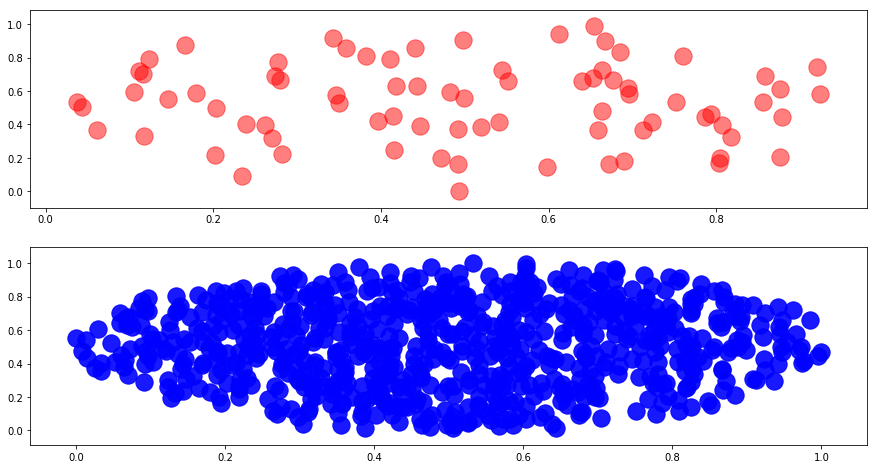

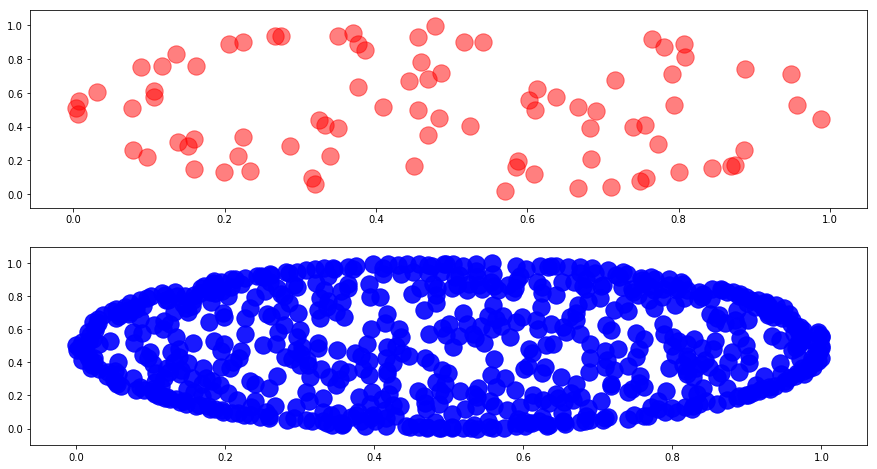

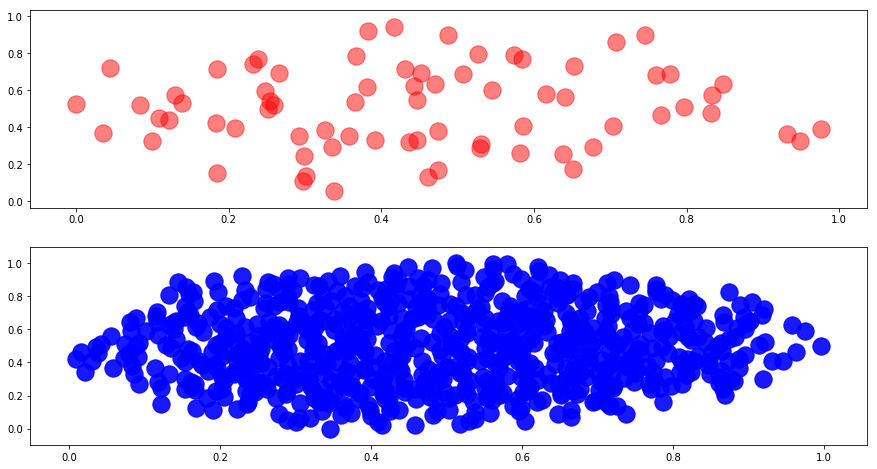

In [254]:
if __name__ == '__main__':
    sng = SocialNetworkGraph(N)
    stable = False
    sng.drawVac()
    sng.updateGraphs()
    plt.show()